In [1]:
import sys
import os

# Add the path to the parent module
sys.path.append(os.path.abspath('../..'))

import warnings
warnings.filterwarnings('ignore')


import deeppy as dp

import torch
import torch.optim as optim
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


import numpy as np
import matplotlib.pyplot as plt

import tiktoken
from datasets import load_dataset


from deeppy import LearnFrame,LayerGenerator,FromLoader
from deeppy.models.nlp.gpt import GPT
from deeppy import GPTText


In [2]:
encoding = tiktoken.encoding_for_model("gpt-2")


vocab_size = encoding.n_vocab
context_size = 16

In [3]:
with open("assets/shakespeare.txt", "r", encoding = "utf-8") as f:
    text = f.read()

data = GPTText(train=text, tokenizer=encoding, context_size = context_size)


In [4]:
Optimizer_params = {
    "optimizer":optim.AdamW,
    "optimizer_args":{"lr":3e-4, "amsgrad" : True, "weight_decay" : 0, "betas" : (0.9, 0.95)},
    "clipper":nn.utils.clip_grad_norm_,
    "clipper_params":{"max_norm" : 1.0},
    "scheduler_params":None,
}

GPT_params = {
    "optimizer_params":Optimizer_params,
    "vocab_size":vocab_size,
    "embed_dim":256,
    "num_heads":4,
    "num_layers":4,
    "context_size":context_size,
    "device":device,
    "criterion":nn.CrossEntropyLoss(ignore_index = -1),
}

model = GPT(**GPT_params)

print(f"Total parameters : {sum(p.numel() for p in model.net.parameters()) / 1e6} Million")

Sequential(
  (0): Embedding(50257, 256)
  (1): OrderedPositionalEmbedding(
    (embed): Embedding(16, 256)
  )
  (2): Dropout(p=0.1, inplace=False)
  (3): MaskedTransformerEncoder(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-3): 4 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=1024, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1024, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
          (activation): GELU(approximate='none')
        )
      )
    )
  )
  (4): LayerNorm((256,), e

In [28]:
for n,i in (model.net.named_modules()):
    print(n)


model
model.0
model.1
model.1.embed
model.2
model.3
model.3.encoder
model.3.encoder.layers
model.3.encoder.layers.0
model.3.encoder.layers.0.self_attn
model.3.encoder.layers.0.self_attn.out_proj
model.3.encoder.layers.0.linear1
model.3.encoder.layers.0.dropout
model.3.encoder.layers.0.linear2
model.3.encoder.layers.0.norm1
model.3.encoder.layers.0.norm2
model.3.encoder.layers.0.dropout1
model.3.encoder.layers.0.dropout2
model.3.encoder.layers.0.activation
model.3.encoder.layers.1
model.3.encoder.layers.1.self_attn
model.3.encoder.layers.1.self_attn.out_proj
model.3.encoder.layers.1.linear1
model.3.encoder.layers.1.dropout
model.3.encoder.layers.1.linear2
model.3.encoder.layers.1.norm1
model.3.encoder.layers.1.norm2
model.3.encoder.layers.1.dropout1
model.3.encoder.layers.1.dropout2
model.3.encoder.layers.1.activation
model.3.encoder.layers.2
model.3.encoder.layers.2.self_attn
model.3.encoder.layers.2.self_attn.out_proj
model.3.encoder.layers.2.linear1
model.3.encoder.layers.2.dropout


In [5]:
lf = LearnFrame(model,data)

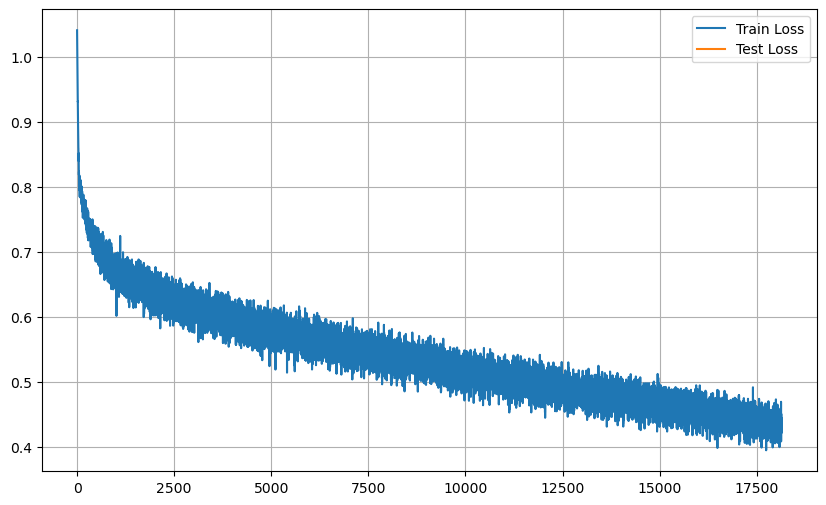

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [7]:
epoch = 20000

for i in range(epoch):
    lf.optimize()
    #lf.test()

    if i % 100 == 0:
        lf.plot(show_result=False, log=True)
lf.plot(show_result=True, log=True, save = "assets/GPT.png")

In [25]:
txt = "KING RICHARD III: \n On this very beautiful day, let us"
for i in range(5):
    inp = torch.tensor(encoding.encode(txt)).unsqueeze(0)
    out = model.generate(inp, context_size).cpu()
    inp = out
    txt += encoding.decode(out.squeeze(0).tolist())
print(txt)

KING RICHARD III: 
 On this very beautiful day, let us us hear
The way of the king.

DUKE OF YORK::
I will not be avoided'd with my heart.

DUKEKE VINCENTIO:
I thank you, good father.

LLUCIO:
I thank you, good my lord; I'll to your your daughter.

KING EDWARD IV:
Now, by the jealous queen
